<a href="https://colab.research.google.com/github/yilmajung/KM4D_v0/blob/main/ksp_pilot_llama70b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/yilmajung/KM4D_v0/blob/main/ksp_pilot_llama70b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KSP Knowledge Extraction with Llama 3.1 70B (Together AI API)

**Same pipeline as `ksp_pilot_complete.ipynb`, but using Llama 3.1 70B Instruct (open-source) instead of Claude Sonnet.**

**Pipeline Overview:**
For each chapter/sub-chapter of a KSP report, this notebook performs:
1. **Taxonomy Classification** — tags sectors & keywords from the development cooperation taxonomy
2. **Knowledge Type** — classifies as one of 4 knowledge types
3. **Korean Policy Extraction** — extracts policy_name, year_initiated, organization, challenge_addressed, policy_instruments, sector
4. **Theory Linking** — matches related theories from development economics textbooks (via RAG)

**LLM Backend:**
- Model: `meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo` via Together AI API
- Cloud inference (~$0.88/M tokens) — no GPU required for LLM
- Embeddings still run locally (sentence-transformers for textbook RAG)

**Prerequisites:**
- Together AI account with API key (https://api.together.xyz)
- `TOGETHER_API_KEY` in Colab Secrets

## Section 1: Setup & Installation

In [1]:
# Install required packages
!pip install -q pymupdf pdfplumber sentence-transformers chromadb pandas numpy scikit-learn matplotlib seaborn plotly networkx
!pip install -q together

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.

In [2]:
# Mount Google Drive for file persistence
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Create project directory in Google Drive
import os
project_dir = '/content/drive/MyDrive/KM4D_v0'
os.makedirs(project_dir, exist_ok=True)
os.makedirs(f'{project_dir}/data/raw/ksp_reports', exist_ok=True)
os.makedirs(f'{project_dir}/data/raw/textbooks', exist_ok=True)
os.makedirs(f'{project_dir}/data/processed', exist_ok=True)
os.makedirs(f'{project_dir}/data/results', exist_ok=True)
os.makedirs(f'{project_dir}/vector_db', exist_ok=True)

print('Project directory created in Google Drive')
print(f'  Location: {project_dir}')

Project directory created in Google Drive
  Location: /content/drive/MyDrive/KM4D_v0


## Section 2: Configuration

In [4]:
import os
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
import json

@dataclass
class Config:
    """Central configuration for the chapter-level analysis pipeline (Llama 3.1 70B via Together AI)."""

    # Directories
    project_dir: str = project_dir
    ksp_dir: str = f'{project_dir}/data/raw/ksp_reports'
    textbook_dir: str = f'{project_dir}/data/raw/textbooks'
    processed_dir: str = f'{project_dir}/data/processed'
    results_dir: str = f'{project_dir}/data/results'
    vector_db_dir: str = f'{project_dir}/vector_db'

    # Textbook chunking parameters
    textbook_chunk_size: int = 768
    chunk_overlap: int = 50

    # Embedding model
    embedding_model: str = 'sentence-transformers/all-MiniLM-L6-v2'

    # LLM (Llama 3.1 70B Instruct via Together AI API)
    llm_model: str = 'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo'
    temperature: float = 0.1
    max_tokens: int = 4096
    max_content_chars: int = 15000

    # Retrieval parameters (textbook only)
    textbook_top_k: int = 3

    # Textbook collection
    textbook_collection: str = 'textbooks_pilot'

    # Output file suffix (to keep separate from Claude results)
    output_suffix: str = '_llama70b'

config = Config()
print('Config initialized')
print(f'  LLM: {config.llm_model} (Together AI API)')
print(f'  Max content chars: {config.max_content_chars}')
print(f'  Max tokens: {config.max_tokens}')

Config initialized
  LLM: meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo (Together AI API)
  Max content chars: 15000
  Max tokens: 4096


In [5]:
# Together AI API Key Setup
# 1. Create an account at https://api.together.xyz
# 2. Get your API key from https://api.together.xyz/settings/api-keys
# 3. Add it as TOGETHER_API_KEY in Colab Secrets (key icon in sidebar)

from google.colab import userdata

try:
    TOGETHER_API_KEY = userdata.get('TOGETHER_API_KEY')
    print('Together AI API key loaded from Colab secrets')
except:
    print('No TOGETHER_API_KEY found in Colab secrets')
    TOGETHER_API_KEY = input('Enter Together AI API key: ')

Together AI API key loaded from Colab secrets


## Section 3: Taxonomy Reference & Knowledge Types

In [6]:
# Full 6-sector, 4-level taxonomy from the Development Cooperation Taxonomy
# Structure: Sector -> Sub-sector L1 -> Sub-sector L2 -> Keywords

TAXONOMY = {
    '(1) Economic Policy': {
        'Macroeconomic Policy & Stability': {
            'Fiscal Policy': [
                'Public Finance Management (PFM)',
                'Tax Policy & Administration',
                'Public Expenditure Management',
                'Sovereign Debt Management',
                'Domestic Revenue Mobilization'
            ],
            'Monetary & Financial Policy': [
                'Financial Sector Development',
                'Monetary Policy & Central Banking',
                'Financial Stability & Regulation',
                'Financial Inclusion'
            ]
        },
        'Inclusive & Sustainable Growth': {
            'Growth Diagnostics & Strategy': [
                'Economic Growth Strategy',
                'Structural Reform',
                'Productivity Analysis',
                'Green Growth'
            ],
            'Poverty & Inequality': [
                'Poverty Reduction Strategy',
                'Inequality Analysis (Income, Wealth)',
                'Social Protection Systems'
            ]
        },
        'Investment & Private Sector Dev.': {
            'Investment Climate': [
                'Investment Policy & Promotion',
                'Business Environment Reform',
                'Competition Policy',
                'Corporate Governance'
            ],
            'Private Sector Support': [
                'Small & Medium Enterprise (SME) Dev.',
                'Foreign Direct Investment (FDI)',
                'Public-Private Partnerships (PPPs)',
                'Entrepreneurship'
            ]
        }
    },
    '(2) Social Services': {
        'Education': {
            'Education Policy & Systems': [
                'Education Policy & Administration',
                'Education Sector Planning',
                'Teacher Training',
                'Educational Facilities'
            ],
            'Levels of Education': [
                'Early Childhood Education',
                'Primary Education',
                'Secondary Education',
                'Higher Education',
                'Vocational Training (TVET)',
                'Adult Education & Lifelong Learning'
            ]
        },
        'Health': {
            'Health Policy & Systems': [
                'Health Policy & Administration',
                'Health Systems Strengthening',
                'Health Financing & Insurance',
                'Health Workforce Development',
                'Digital Health'
            ],
            'Health Services & Outcomes': [
                'Basic Health Care',
                'Maternal & Child Health',
                'Infectious Disease Control (HIV/AIDS, TB)',
                'Non-Communicable Diseases (NCDs)',
                'Mental Health',
                'Pandemic Preparedness & Response'
            ]
        },
        'Social Protection & Inclusion': {
            'Social Welfare Services': [
                'Social/Welfare Services',
                'Child Protection',
                'Services for the Elderly & Disabled'
            ]
        },
        'Cross-Cutting Social Issues': {
            'Gender Equality & Empowerment': [
                'Gender Equality',
                "Women's Economic Empowerment",
                'Ending Violence Against Women & Girls',
                'Youth Development & Employment',
                'Food Security & Nutrition'
            ]
        }
    },
    '(3) Digital Innovation': {
        'Digital Policy & Governance': {
            'Digital Strategy & Regulation': [
                'National Digital Strategy',
                'Data Governance & Privacy',
                'Cybersecurity Policy',
                'AI Governance & Ethics',
                'Digital Taxation'
            ]
        },
        'Digital Infrastructure': {
            'Connectivity': [
                'Universal Connectivity',
                'Broadband Infrastructure',
                'Mobile Networks (5G)'
            ],
            'Core Digital Systems': [
                'Digital Public Infrastructure (DPI)',
                'Digital Identity Systems',
                'Digital Payment Systems'
            ]
        },
        'Digital Transformation': {
            'Digital Inclusion & Skills': [
                'Digital Literacy & Skills',
                'Addressing the Digital Divide',
                'Gender and Digital Inclusion'
            ],
            'Digital Economy & Services': [
                'E-Commerce',
                'Digital Financial Services (FinTech)',
                'E-Government Services',
                'Digital Entrepreneurship',
                'Platform Economy'
            ]
        },
        'Emerging Technologies': {
            'Technology Adoption': [
                'Artificial Intelligence (AI)',
                'Internet of Things (IoT)',
                'Blockchain',
                'Big Data Analytics'
            ],
            'Digital Public Goods': [
                'Open Source Software & Data',
                'Open Standards'
            ]
        }
    },
    '(4) Production & Trade': {
        'Agriculture, Forestry & Fisheries': {
            'Agricultural Development': [
                'Agricultural Policy & Administration',
                'Agricultural Research & Extension',
                'Sustainable Agriculture',
                'Agricultural Value Chains',
                'Smallholder Farmer Support'
            ],
            'Forestry & Fisheries': [
                'Forestry Development',
                'Sustainable Forest Management',
                'Fisheries Development',
                'Aquaculture'
            ]
        },
        'Industry & Services': {
            'Industrial Development': [
                'Industrial Policy',
                'Manufacturing',
                'Agro-industry',
                'Mineral Resources & Mining'
            ],
            'Services Sector Development': [
                'Tourism Development',
                'Business & Other Services'
            ]
        },
        'Trade Policy & Facilitation': {
            'Trade Policy & Regulation': [
                'Trade Policy & Regulations',
                'WTO Accession & Compliance',
                'Regional Trade Agreements'
            ],
            'Trade Facilitation': [
                'Customs Modernization',
                'Border Management',
                'Aid for Trade',
                'Global Value Chains (GVCs)'
            ]
        }
    },
    '(5) Infrastructure': {
        'Infrastructure Policy & Finance': {
            'Infrastructure Governance': [
                'Infrastructure Policy & Planning',
                'Infrastructure Governance',
                'Public Investment Management'
            ],
            'Infrastructure Finance': [
                'Infrastructure Financing',
                'Private Investment in Infrastructure',
                'Blended Finance'
            ]
        },
        'Transport': {
            'Transport Policy & Planning': [
                'Transport Policy & Administration',
                'Urban Transport',
                'Rural Transport'
            ],
            'Transport Modalities': [
                'Road Transport',
                'Rail Transport',
                'Water Transport (Ports, Inland)',
                'Air Transport'
            ]
        },
        'Water & Sanitation': {
            'Water & Sanitation Policy': [
                'Water & Sanitation Policy',
                'Integrated Water Resource Management'
            ],
            'Water & Sanitation Services': [
                'Water Supply Systems',
                'Sanitation & Hygiene (WASH)',
                'Wastewater Management'
            ]
        },
        'Urban & Rural Development': {
            'Urban Development': [
                'Urban Development & Management',
                'Affordable Housing'
            ],
            'Rural Development': [
                'Rural Development'
            ]
        }
    },
    '(6) Energy & Environment': {
        'Environmental Policy & Management': {
            'Environmental Governance': [
                'Environmental Policy & Admin. Management',
                'Biosafety & Biodiversity',
                'Water Resources Protection',
                'Circular Economy'
            ]
        },
        'Climate Change': {
            'Climate Change Mitigation': [
                'Renewable Energy Generation',
                'Energy Efficiency',
                'Greenhouse Gas (GHG) Reduction',
                'Carbon Markets & Pricing'
            ],
            'Climate Change Adaptation': [
                'Climate Adaptation Strategies',
                'Disaster Risk Reduction (DRR)',
                'Climate Resilient Infrastructure',
                'Climate Finance'
            ]
        },
        'Energy': {
            'Energy Policy & Access': [
                'Energy Policy & Planning',
                'Universal Energy Access',
                'Just Energy Transition (JET)',
                'Energy Sector Reform & Regulation'
            ],
            'Energy Generation & Supply': [
                'Renewable Energy (Solar, Wind, Hydro)',
                'Non-Renewable Energy (Fossil Fuels)',
                'Energy Transmission & Distribution'
            ]
        }
    }
}

# Knowledge types for classifying chapter content
KNOWLEDGE_TYPES = [
    'Policy Entrepreneurship (leadership)',
    'Policy Implementation & Coordinating Mechanism',
    'Organizational/Individual Capacity',
    'Technical Know-how'
]


def taxonomy_to_prompt_string() -> str:
    """Convert TAXONOMY dict to a readable string for LLM prompts."""
    lines = []
    for sector, l1_dict in TAXONOMY.items():
        lines.append(f'\n{sector}')
        for l1, l2_dict in l1_dict.items():
            lines.append(f'  {l1}')
            for l2, keywords in l2_dict.items():
                lines.append(f'    {l2}')
                for kw in keywords:
                    lines.append(f'      - {kw}')
    return '\n'.join(lines)


def get_all_valid_keywords() -> set:
    """Get flat set of all valid keywords for validation."""
    keywords = set()
    for sector, l1_dict in TAXONOMY.items():
        for l1, l2_dict in l1_dict.items():
            for l2, kw_list in l2_dict.items():
                keywords.update(kw_list)
    return keywords


all_keywords = get_all_valid_keywords()
print(f'Taxonomy loaded: {len(TAXONOMY)} sectors, {len(all_keywords)} keywords')
print(f'Knowledge types: {len(KNOWLEDGE_TYPES)}')
print()
for sector in TAXONOMY:
    n_kw = sum(len(kw) for l1 in TAXONOMY[sector].values() for kw in l1.values())
    print(f'  {sector}: {n_kw} keywords')

Taxonomy loaded: 6 sectors, 140 keywords
Knowledge types: 4

  (1) Economic Policy: 24 keywords
  (2) Social Services: 29 keywords
  (3) Digital Innovation: 25 keywords
  (4) Production & Trade: 22 keywords
  (5) Infrastructure: 21 keywords
  (6) Energy & Environment: 19 keywords


## Section 4: Chapter Extraction from KSP Reports (TOC Parsing)

Extracts chapters by parsing the Table of Contents pages:
- Detects dot-leader patterns (`.`, `…`, `·`, `∙`) to find TOC pages
- Filters out figure/table list pages
- Handles multi-line titles and page number resolution
- Truncates at page wrap-around to exclude appendix table/figure lists

In [7]:
import fitz  # PyMuPDF
import re
from pathlib import Path
from collections import defaultdict, Counter


class TOCChapterExtractor:
    """Extract chapters from KSP reports by parsing the Table of Contents pages.

    Approach:
    - Find TOC pages by detecting dot-leader patterns (., …, ·, ∙)
    - Filter out figure/table list pages
    - Parse TOC entries with multi-line title support
    - Resolve TOC page numbers to actual PDF page indices
    - Truncate at page wrap-around (catches table/figure list residue)
    - Extract text for each chapter by page range

    Returns dicts compatible with the downstream ChapterAnalyzer pipeline.
    """

    # 2+ repeated dot-leader chars (covers ., …, ·, ∙ across all report styles)
    DOT_LEADER_RE = re.compile(r'[.…·∙\u00B7\u2026\u2219]{2,}')
    PAGE_NUM_RE = re.compile(r'[.…·∙\u00B7\u2026\u2219\s]*(\d{1,3})\s*$')
    LIST_HEADER_RE = re.compile(
        r'List\s+of\s+(Tables?|Figures?|Pictures?|Exhibits?)', re.IGNORECASE
    )

    def __init__(self, pdf_path: str):
        self.pdf_path = pdf_path
        self.filename = Path(pdf_path).stem
        self.doc = fitz.open(pdf_path)
        self.metadata = self._extract_metadata()

    def close(self):
        self.doc.close()

    def _extract_metadata(self) -> Dict:
        """Extract metadata from filename (YYYY_CCC_Title.pdf)."""
        pattern = r'(\d{4})_([A-Z]{3})_(.+)'
        match = re.match(pattern, self.filename)
        if match:
            return {
                'year': match.group(1),
                'country': match.group(2),
                'title': match.group(3).replace('_', ' '),
                'filename': self.filename
            }
        return {'filename': self.filename}

    def _find_toc_pages(self) -> List[int]:
        """Find content TOC pages, excluding figure/table list pages."""
        candidates = []
        max_page = min(len(self.doc), max(20, int(len(self.doc) * 0.15)))

        for pg_idx in range(max_page):
            text = self.doc[pg_idx].get_text()
            lines = text.split('\n')
            dot_count = sum(
                1 for l in lines
                if self.DOT_LEADER_RE.search(l) and self.PAGE_NUM_RE.search(l)
            )
            if dot_count >= 3:
                is_list = bool(self.LIST_HEADER_RE.search(text[:500]))
                if not is_list:
                    fig_entries = sum(
                        1 for l in lines
                        if self.DOT_LEADER_RE.search(l) and self.PAGE_NUM_RE.search(l)
                        and re.match(
                            r'^\s*(\[?\s*(Figure|Table|Picture|Exhibit)\b|<\s*(Table|Figure))',
                            l.strip(), re.IGNORECASE
                        )
                    )
                    if dot_count > 0 and fig_entries / dot_count > 0.5:
                        is_list = True
                candidates.append((pg_idx, is_list))

        # Check adjacent pages for continuation
        known = {pg for pg, _ in candidates}
        for pg, _ in list(candidates):
            for adj in [pg - 1, pg + 1]:
                if 0 <= adj < max_page and adj not in known:
                    text = self.doc[adj].get_text()
                    lines = text.split('\n')
                    dc = sum(
                        1 for l in lines
                        if self.DOT_LEADER_RE.search(l) and self.PAGE_NUM_RE.search(l)
                    )
                    if dc >= 2:
                        is_list = bool(self.LIST_HEADER_RE.search(text[:500]))
                        if not is_list:
                            fe = sum(
                                1 for l in lines
                                if self.DOT_LEADER_RE.search(l) and self.PAGE_NUM_RE.search(l)
                                and re.match(
                                    r'^\s*(\[?\s*(Figure|Table|Picture)\b|<\s*(Table|Figure))',
                                    l.strip(), re.IGNORECASE
                                )
                            )
                            if dc > 0 and fe / dc > 0.5:
                                is_list = True
                        candidates.append((adj, is_list))
                        known.add(adj)

        candidates.sort()
        # Return only content pages; stop at first list page
        content_pages = []
        for pg, is_list in candidates:
            if is_list:
                break
            content_pages.append(pg)
        return content_pages

    def _parse_toc_entries(self, toc_pages: List[int]) -> List[Dict]:
        """Parse TOC entries from identified TOC pages, handling multi-line titles."""
        entries = []

        for pg_idx in toc_pages:
            text = self.doc[pg_idx].get_text()
            lines = text.split('\n')

            i = 0
            while i < len(lines):
                stripped = lines[i].strip()

                # Skip empty lines, headers
                if not stripped or stripped.lower() in ('contents', 'table of contents'):
                    i += 1
                    continue
                if re.match(r'^Chapter\s+\d+\s*$', stripped, re.IGNORECASE):
                    i += 1
                    continue

                # --- Line has dot leaders ---
                if self.DOT_LEADER_RE.search(stripped):
                    pm = self.PAGE_NUM_RE.search(stripped)
                    if pm:
                        title = self.DOT_LEADER_RE.split(stripped)[0].strip()
                        if not title or len(title) < 3:
                            i += 1
                            continue
                        # Skip table/figure entries
                        if re.match(
                            r'^(<\s*(Table|Figure)|\[?\s*(Figure|Table|Picture))',
                            title, re.IGNORECASE
                        ):
                            i += 1
                            continue
                        title = re.sub(r'\s+', ' ', title).rstrip('.…·∙ ')
                        entries.append({
                            'title': title,
                            'page_num': int(pm.group(1)),
                            'level': self._detect_level(title)
                        })
                        i += 1
                        continue

                    # Dots but no page number — look ahead
                    title_so_far = self.DOT_LEADER_RE.split(stripped)[0].strip()
                    found = False
                    for j in range(i + 1, min(i + 3, len(lines))):
                        ns = lines[j].strip()
                        if not ns:
                            continue
                        pm = self.PAGE_NUM_RE.search(ns)
                        if pm:
                            tp = self.DOT_LEADER_RE.split(ns)[0].strip()
                            combined = (title_so_far + ' ' + tp).strip() if tp else title_so_far
                            combined = re.sub(r'\s+', ' ', combined).rstrip('.…·∙ ')
                            if len(combined) >= 3:
                                entries.append({
                                    'title': combined,
                                    'page_num': int(pm.group(1)),
                                    'level': self._detect_level(combined)
                                })
                            i = j + 1
                            found = True
                            break
                        break
                    if not found:
                        i += 1
                    continue

                # --- No dots: check for multi-line title ---
                found = False
                combined = stripped
                for j in range(i + 1, min(i + 4, len(lines))):
                    ns = lines[j].strip()
                    if not ns:
                        continue
                    if self.DOT_LEADER_RE.search(ns):
                        pm = self.PAGE_NUM_RE.search(ns)
                        if pm:
                            tp = self.DOT_LEADER_RE.split(ns)[0].strip()
                            # Don't concatenate if dotted line is a standalone numbered entry
                            if re.match(r'^\d+[\.\)]\s', tp) or re.match(r'^[A-Z]\.\s', tp):
                                break
                            if tp:
                                combined += ' ' + tp
                            combined = re.sub(r'\s+', ' ', combined).rstrip('.…·∙ ')
                            if len(combined) >= 3:
                                entries.append({
                                    'title': combined,
                                    'page_num': int(pm.group(1)),
                                    'level': self._detect_level(combined)
                                })
                            i = j + 1
                            found = True
                            break
                    # If next line starts a new numbered entry, stop
                    if re.match(r'^\d+[\.\)]\s', ns) or re.match(r'^[A-Z]\.\s', ns):
                        break
                    combined += ' ' + ns

                if not found:
                    i += 1

        return entries

    def _detect_level(self, title: str) -> int:
        """Detect hierarchy level from title numbering pattern."""
        t = title.strip()
        if re.match(r'^Chapter\s+\d', t, re.IGNORECASE):
            return 0
        if re.match(r'^\d{1,2}\.\s', t):
            return 1
        if re.match(r'^[A-Z]\.\s', t):
            return 1
        if re.match(r'^\d+\.\d+\.?\s', t):
            return 2
        if re.match(r'^\d+\)\s', t):
            return 2
        if re.match(r'^\d+\.\d+\.\d+', t):
            return 3
        return 1

    def _resolve_page_numbers(self, entries: List[Dict]) -> List[Dict]:
        """Resolve TOC page numbers to PDF page indices; truncate at page wrap-around."""
        if not entries:
            return entries

        # Detect page offset by sampling entries
        offsets = []
        indices = (
            list(range(min(5, len(entries))))
            + list(range(len(entries) // 2, min(len(entries) // 2 + 3, len(entries))))
        )
        for idx in indices:
            entry = entries[idx]
            st = re.sub(r'^\d+[\.\)]\s*', '', entry['title'])
            st = re.sub(r'^[A-Z]\.\s*', '', st)
            st = re.sub(r'^\d+\.\d+\.?\s*', '', st)
            if len(st) < 5:
                continue
            search = st[:40].strip()
            exp = entry['page_num']
            for pg in range(max(0, exp - 10), min(len(self.doc), exp + 10)):
                if search in self.doc[pg].get_text():
                    offsets.append(pg - exp)
                    break

        best = Counter(offsets).most_common(1)[0][0] if offsets else 0

        for e in entries:
            e['pdf_page'] = max(0, min(e['page_num'] + best, len(self.doc) - 1))

        # Truncate at page wrap-around
        mx = entries[0]['pdf_page']
        for i in range(1, len(entries)):
            if entries[i]['pdf_page'] < mx - 5:
                return entries[:i]
            mx = max(mx, entries[i]['pdf_page'])

        return entries

    def extract_chapters(self, level_filter: Optional[int] = 1) -> List[Dict]:
        """Extract chapters from PDF using TOC parsing.

        Args:
            level_filter: Max level to include (1 = chapters + sections, 2 = include
                         subsections). None = all levels.

        Returns:
            List of dicts with keys: chapter_title, chapter_level, content,
            page_start, page_end, content_length.
        """
        toc_pages = self._find_toc_pages()
        if not toc_pages:
            print(f'  WARNING: No TOC pages found in {self.filename}')
            return []

        print(f'  TOC pages (PDF): {[p + 1 for p in toc_pages]}')

        entries = self._parse_toc_entries(toc_pages)
        if not entries:
            print(f'  WARNING: No TOC entries parsed')
            return []

        print(f'  Parsed {len(entries)} TOC entries')

        if level_filter is not None:
            entries = [e for e in entries if e['level'] <= level_filter]
            print(f'  After level filter (\u2264{level_filter}): {len(entries)}')

        entries = self._resolve_page_numbers(entries)
        print(f'  After page resolution: {len(entries)}')

        # Build chapter dicts with text content
        chapters = []
        for i, entry in enumerate(entries):
            ps = entry['pdf_page']
            pe = entries[i + 1]['pdf_page'] if i + 1 < len(entries) else len(self.doc)

            if pe <= ps:
                continue  # Skip 0-content entries (parent headers)

            content = '\n'.join(
                self.doc[pg].get_text()
                for pg in range(ps, pe)
                if 0 <= pg < len(self.doc)
            )

            chapters.append({
                'chapter_title': entry['title'],
                'chapter_level': entry['level'],
                'content': content,
                'page_start': ps + 1,  # 1-indexed for display
                'page_end': pe,
                'content_length': len(content)
            })

        return chapters

    def get_summary(self) -> Dict:
        """Get a summary of the extracted chapters."""
        chapters = self.extract_chapters()
        return {
            'filename': self.filename,
            'metadata': self.metadata,
            'num_chapters': len(chapters),
            'chapters': [
                {
                    'title': ch['chapter_title'],
                    'level': ch['chapter_level'],
                    'pages': f"{ch['page_start']}-{ch['page_end']}",
                    'chars': ch['content_length']
                }
                for ch in chapters
            ]
        }


print('TOCChapterExtractor class defined')

TOCChapterExtractor class defined


In [8]:
# Test TOC-based chapter extraction on one report
ksp_pdfs = list(Path(config.ksp_dir).glob('*.pdf'))
if ksp_pdfs:
    test_pdf = str(ksp_pdfs[0])
    print(f'Testing on: {Path(test_pdf).name}')
    print()

    extractor = TOCChapterExtractor(test_pdf)
    print(f'Metadata: {extractor.metadata}')

    chapters = extractor.extract_chapters(level_filter=1)
    print(f'\nExtracted {len(chapters)} chapters/sections')
    print()
    for i, ch in enumerate(chapters[:15]):
        level_marker = '  ' * ch['chapter_level']
        print(f"{level_marker}[L{ch['chapter_level']}] {ch['chapter_title'][:80]}")
        print(f"{level_marker}     Pages {ch['page_start']}-{ch['page_end']}, {ch['content_length']:,} chars")
    if len(chapters) > 15:
        print(f'  ... and {len(chapters) - 15} more')

    extractor.close()
else:
    print(f'No KSP reports found in: {config.ksp_dir}')
    print('Please upload PDF reports to this directory')

Testing on: 2009_VNM_Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy_E.pdf

Metadata: {'year': '2009', 'country': 'VNM', 'title': 'Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy E', 'filename': '2009_VNM_Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy_E'}
  TOC pages (PDF): [17, 18, 19]
  Parsed 64 TOC entries
  After level filter (≤1): 64
  After page resolution: 64

Extracted 52 chapters/sections

  [L1] 1. Assessment of Vietnam’s Economic Growth Performance
       Pages 31-31, 1,530 chars
  [L1] 2. Projection of GDP Growth
       Pages 32-33, 4,046 chars
  [L1] 3. Suggested Policy Priorities for Strengthening and Sustaining Vietna
       Pages 34-34, 2,150 chars
  [L1] 1. Introduction
       Pages 35-35, 2,058 chars
  [L1] 2. Overview and Assessment of the Vietnamese Economic Development: 1986-2009
       Pages 36-85, 115,781 chars
  [L1] 3. Evaluation of Vietnam’s Econ

## Section 5: Textbook Vector Store (for Theory Linking)

In [9]:
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings
from tqdm import tqdm
import numpy as np


class VectorStore:
    """Manage embeddings and ChromaDB vector database for textbooks."""

    def __init__(self, collection_name: str, persist_directory: str = None):
        self.collection_name = collection_name

        # Initialize embedding model
        print(f'Loading embedding model: {config.embedding_model}...')
        self.embedding_model = SentenceTransformer(config.embedding_model)
        print('Embedding model loaded')

        # Initialize ChromaDB with persistence
        if persist_directory is None:
            persist_directory = config.vector_db_dir

        self.client = chromadb.Client(Settings(
            persist_directory=persist_directory,
            anonymized_telemetry=False
        ))

        try:
            self.collection = self.client.get_collection(name=collection_name)
            print(f'Loaded existing collection: {collection_name}')
        except:
            self.collection = self.client.create_collection(
                name=collection_name,
                metadata={'description': f'Collection for {collection_name}'}
            )
            print(f'Created new collection: {collection_name}')

    def add_documents(self, chunks: List[Dict], batch_size: int = 32):
        """Add document chunks to vector database."""
        documents = [chunk['text'] for chunk in chunks]
        metadatas = [chunk['metadata'] for chunk in chunks]
        ids = [chunk['metadata']['chunk_id'] for chunk in chunks]

        print(f'Adding {len(documents)} documents to {self.collection_name}...')

        all_embeddings = []
        for i in tqdm(range(0, len(documents), batch_size), desc='Embedding'):
            batch_docs = documents[i:i+batch_size]
            embeddings = self.embedding_model.encode(
                batch_docs, show_progress_bar=False, convert_to_numpy=True
            ).tolist()
            all_embeddings.extend(embeddings)

        for i in tqdm(range(0, len(documents), batch_size), desc='Storing'):
            batch_end = min(i + batch_size, len(documents))
            self.collection.add(
                documents=documents[i:batch_end],
                embeddings=all_embeddings[i:batch_end],
                metadatas=metadatas[i:batch_end],
                ids=ids[i:batch_end]
            )

        print(f'Added {len(documents)} chunks to collection')

    def search(self, query: str, n_results: int = 5, filter_dict: Dict = None) -> Dict:
        """Search for relevant chunks."""
        query_embedding = self.embedding_model.encode([query])[0].tolist()
        results = self.collection.query(
            query_embeddings=[query_embedding],
            n_results=n_results,
            where=filter_dict
        )
        return results

    def get_stats(self) -> Dict:
        """Get collection statistics."""
        return {
            'collection_name': self.collection_name,
            'total_chunks': self.collection.count()
        }


print('VectorStore class defined')

VectorStore class defined


In [10]:
# Initialize textbook vector store
print('\n' + '='*60)
print('INITIALIZING TEXTBOOK VECTOR DATABASE')
print('='*60)

textbook_store = VectorStore(
    collection_name=config.textbook_collection,
    persist_directory=config.vector_db_dir
)

print(f'\nTextbook store initialized')
print(f'  ChromaDB persisted to: {config.vector_db_dir}')
print(f'  Current stats: {textbook_store.get_stats()}')


INITIALIZING TEXTBOOK VECTOR DATABASE
Loading embedding model: sentence-transformers/all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding model loaded
Created new collection: textbooks_pilot

Textbook store initialized
  ChromaDB persisted to: /content/drive/MyDrive/KM4D_v0/vector_db
  Current stats: {'collection_name': 'textbooks_pilot', 'total_chunks': 0}


In [11]:
!pip install -q langchain langchain-text-splitters

In [12]:
# Index textbooks (run once; skip if already indexed)
from langchain_text_splitters import RecursiveCharacterTextSplitter


def process_and_index_textbooks():
    """Process textbooks and add to vector database."""
    textbook_dir = Path(config.textbook_dir)
    pdf_files = list(textbook_dir.glob('*.pdf'))

    print(f'\nFound {len(pdf_files)} textbooks')

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=config.textbook_chunk_size,
        chunk_overlap=config.chunk_overlap,
        separators=['\n\n', '\n', '. ', ' ', ''],
        length_function=len
    )

    all_chunks = []

    for pdf_path in pdf_files:
        print(f'\nProcessing: {pdf_path.name}')

        # Extract text with sections via PyMuPDF
        doc = fitz.open(str(pdf_path))
        sections = []
        current_section = {'title': 'Introduction', 'content': '', 'page': 1}

        for page_num, page in enumerate(doc, 1):
            blocks = page.get_text('dict')['blocks']
            for block in blocks:
                if 'lines' not in block:
                    continue
                for line in block['lines']:
                    text = ''
                    font_size = 0
                    for span in line['spans']:
                        text += span['text']
                        font_size = max(font_size, span['size'])
                    text = text.strip()
                    if not text:
                        continue
                    if font_size > 12 and len(text) < 100:
                        if current_section['content'].strip():
                            sections.append(current_section)
                        current_section = {'title': text, 'content': '', 'page': page_num}
                    else:
                        current_section['content'] += text + '\n'

        if current_section['content'].strip():
            sections.append(current_section)
        doc.close()

        print(f'  Extracted {len(sections)} sections')

        # Chunk sections
        filename = pdf_path.stem
        metadata_base = {'source_type': 'textbook', 'filename': filename}

        for s_idx, section in enumerate(sections):
            sub_chunks = splitter.split_text(section['content'])
            for c_idx, chunk_text in enumerate(sub_chunks):
                all_chunks.append({
                    'text': chunk_text,
                    'metadata': {
                        **metadata_base,
                        'section_title': section['title'],
                        'section_index': s_idx,
                        'section_page': section['page'],
                        'chunk_index': c_idx,
                        'chunk_id': f'{filename}_s{s_idx}_c{c_idx}'
                    }
                })

        print(f'  Created {sum(1 for c in all_chunks if c["metadata"]["filename"] == filename)} chunks')

    # Add to vector database
    if all_chunks:
        textbook_store.add_documents(all_chunks)

        output_path = f'{config.processed_dir}/textbook_chunks.json'
        with open(output_path, 'w') as f:
            json.dump(all_chunks, f, indent=2)
        print(f'\nSaved processed chunks to: {output_path}')

    return all_chunks


# Check if textbooks are already indexed
stats = textbook_store.get_stats()
if stats['total_chunks'] > 0:
    print(f'\nTextbooks already indexed: {stats["total_chunks"]} chunks')
    print('  Skipping re-indexing. Delete collection to re-index.')
else:
    textbook_pdfs = list(Path(config.textbook_dir).glob('*.pdf'))
    if len(textbook_pdfs) == 0:
        print(f'\nNo textbooks found in: {config.textbook_dir}')
        print('Please upload textbook PDFs to this directory')
    else:
        print(f'\nFound {len(textbook_pdfs)} textbooks. Indexing...')
        textbook_chunks = process_and_index_textbooks()
        print(f'\nTextbook Collection: {textbook_store.get_stats()}')


Found 2 textbooks. Indexing...

Found 2 textbooks

Processing: Perkins et al_2012.pdf
  Extracted 87 sections
  Created 3273 chunks

Processing: Todoro_2012.pdf
  Extracted 281 sections
  Created 3921 chunks
Adding 7194 documents to textbooks_pilot...


Storing: 100%|██████████| 225/225 [00:13<00:00, 16.47it/s]


Added 7194 chunks to collection

Saved processed chunks to: /content/drive/MyDrive/KM4D_v0/data/processed/textbook_chunks.json

Textbook Collection: {'collection_name': 'textbooks_pilot', 'total_chunks': 7194}


## Section 6: Process All KSP Reports (Chapter Extraction)

In [13]:
def extract_all_chapters() -> Dict[str, List[Dict]]:
    """Extract chapters from all KSP PDF reports using TOC parsing.

    Returns dict mapping report_id -> {'metadata': ..., 'chapters': [...]}.
    """
    ksp_dir = Path(config.ksp_dir)
    pdf_files = sorted(ksp_dir.glob('*.pdf'))

    print(f'Found {len(pdf_files)} KSP reports')

    all_reports = {}

    for pdf_path in pdf_files:
        print(f'\n{"="*60}')
        print(f'Processing: {pdf_path.name}')
        print('='*60)

        extractor = TOCChapterExtractor(str(pdf_path))
        chapters = extractor.extract_chapters(level_filter=1)

        report_id = extractor.filename
        all_reports[report_id] = {
            'metadata': extractor.metadata,
            'chapters': chapters
        }

        print(f'  Extracted {len(chapters)} chapters/sections')
        total_chars = sum(ch['content_length'] for ch in chapters)
        print(f'  Total text: {total_chars:,} characters')

        # Show chapter outline
        for ch in chapters[:15]:
            indent = '  ' * ch['chapter_level']
            print(f"  {indent}[L{ch['chapter_level']}] {ch['chapter_title'][:70]}  ({ch['content_length']:,} chars)")
        if len(chapters) > 15:
            print(f'  ... and {len(chapters) - 15} more')

        extractor.close()

    # Save chapter summaries
    summary = {}
    for report_id, data in all_reports.items():
        summary[report_id] = {
            'metadata': data['metadata'],
            'num_chapters': len(data['chapters']),
            'chapters': [
                {
                    'title': ch['chapter_title'],
                    'level': ch['chapter_level'],
                    'pages': f"{ch['page_start']}-{ch['page_end']}",
                    'chars': ch['content_length']
                }
                for ch in data['chapters']
            ]
        }

    summary_path = f'{config.processed_dir}/chapter_summaries.json'
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    print(f'\nChapter summaries saved to: {summary_path}')

    return all_reports


# Extract chapters from all reports
print('\n' + '='*60)
print('PHASE 1: CHAPTER EXTRACTION (TOC-based)')
print('='*60)

all_reports = extract_all_chapters()

total_chapters = sum(len(data['chapters']) for data in all_reports.values())
print(f'\nTotal: {total_chapters} chapters/sections from {len(all_reports)} reports')


PHASE 1: CHAPTER EXTRACTION (TOC-based)
Found 4 KSP reports

Processing: 2009_VNM_Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy_E.pdf
  TOC pages (PDF): [17, 18, 19]
  Parsed 64 TOC entries
  After level filter (≤1): 64
  After page resolution: 64
  Extracted 52 chapters/sections
  Total text: 985,989 characters
    [L1] 1. Assessment of Vietnam’s Economic Growth Performance  (1,530 chars)
    [L1] 2. Projection of GDP Growth  (4,046 chars)
    [L1] 3. Suggested Policy Priorities for Strengthening and Sustaining Vietna  (2,150 chars)
    [L1] 1. Introduction  (2,058 chars)
    [L1] 2. Overview and Assessment of the Vietnamese Economic Development: 198  (115,781 chars)
    [L1] 3. Evaluation of Vietnam’s Economic Growth from an International Persp  (56,425 chars)
    [L1] 4. Key Policy Challenges  (17,026 chars)
    [L1] 1. Enhancing Early Warning System and Risk Management Capacity  (4,220 chars)
    [L1] 2. Capital Account Liberalization in Vie

## Section 7: Initialize Together AI Client

Connect to Together AI API for Llama 3.1 70B Instruct inference.

In [14]:
from together import Together

# Initialize Together AI client
client = Together(api_key=TOGETHER_API_KEY)

# Test the connection with a simple query
test_response = client.chat.completions.create(
    model=config.llm_model,
    messages=[{'role': 'user', 'content': 'Say "hello" in JSON: {"greeting": "..."}'}],
    max_tokens=50,
    temperature=0.1
)
print(f'Together AI client initialized')
print(f'  Model: {config.llm_model}')
print(f'  Test response: {test_response.choices[0].message.content}')

Together AI client initialized
  Model: meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo
  Test response: {"greeting": "hello"}


## Section 8: LLM Classification + Extraction (Combined Prompt)

In [15]:
import time


def extract_json_from_text(text: str) -> Optional[Dict]:
    """Extract JSON from LLM output, handling common formatting issues.

    Llama models sometimes wrap JSON in markdown fences, add preamble text,
    or produce slightly malformed JSON. This function tries multiple
    extraction strategies.
    """
    # Strategy 1: Direct parse
    text = text.strip()
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        pass

    # Strategy 2: Strip markdown fences
    cleaned = text
    if '```json' in cleaned:
        cleaned = cleaned.split('```json', 1)[1]
    elif '```' in cleaned:
        cleaned = cleaned.split('```', 1)[1]
    if cleaned.endswith('```'):
        cleaned = cleaned[:-3]
    cleaned = cleaned.strip()
    try:
        return json.loads(cleaned)
    except json.JSONDecodeError:
        pass

    # Strategy 3: Find outermost { ... } block
    first_brace = text.find('{')
    last_brace = text.rfind('}')
    if first_brace != -1 and last_brace > first_brace:
        candidate = text[first_brace:last_brace + 1]
        try:
            return json.loads(candidate)
        except json.JSONDecodeError:
            pass

    # Strategy 4: Fix common issues (trailing commas, single quotes)
    if first_brace != -1 and last_brace > first_brace:
        candidate = text[first_brace:last_brace + 1]
        # Remove trailing commas before } or ]
        candidate = re.sub(r',\s*([}\]])', r'\1', candidate)
        try:
            return json.loads(candidate)
        except json.JSONDecodeError:
            pass

    return None


class ChapterAnalyzer:
    """Analyze KSP report chapters using Llama 3.1 70B via Together AI API.

    For each chapter, performs:
    1. Taxonomy sector/keyword classification
    2. Knowledge type classification
    3. Korean policy extraction
    4. Theory linking (using textbook RAG context)
    """

    def __init__(self, client: Together, textbook_store: VectorStore):
        self.client = client
        self.textbook_store = textbook_store
        self.taxonomy_string = taxonomy_to_prompt_string()

    def _get_theory_context(self, chapter_title: str, chapter_content: str) -> str:
        """Query textbook store for relevant theory passages."""
        content_snippet = chapter_content[:200].replace('\n', ' ')
        query = f'{chapter_title} {content_snippet}'

        try:
            results = self.textbook_store.search(
                query=query,
                n_results=config.textbook_top_k
            )
            if results['documents'][0]:
                return '\n\n---\n\n'.join(results['documents'][0])
        except Exception as e:
            print(f'  Warning: Theory retrieval failed: {e}')

        return ''

    def _build_prompt(self, chapter_title: str, chapter_content: str,
                      theory_context: str) -> str:
        """Build the combined classification + extraction prompt."""

        # Truncate long chapters
        max_content_chars = config.max_content_chars
        if len(chapter_content) > max_content_chars:
            chapter_content = chapter_content[:max_content_chars] + '\n\n[... content truncated ...]'

        theory_section = theory_context if theory_context else 'No textbook passages retrieved.'

        return f"""You are analyzing a chapter from a KSP (Knowledge Sharing Program) development cooperation report.

CHAPTER TITLE: {chapter_title}

CHAPTER CONTENT:
{chapter_content}

RELATED THEORETICAL PASSAGES (from development economics textbooks):
{theory_section}

DEVELOPMENT COOPERATION TAXONOMY:
{self.taxonomy_string}

KNOWLEDGE TYPES:
1. Policy Entrepreneurship (leadership)
2. Policy Implementation & Coordinating Mechanism
3. Organizational/Individual Capacity
4. Technical Know-how

TASK: Perform ALL of the following analyses on this chapter.

1. TAXONOMY CLASSIFICATION: Identify which sector(s) and keywords from the taxonomy above best describe this chapter's content. A chapter may map to multiple sectors. Select the most specific keywords that apply.

2. KNOWLEDGE TYPE: Classify this chapter as one of the 4 knowledge types listed above.

3. KOREAN POLICY EXTRACTION: Extract any Korean government policies, programs, or initiatives described in this chapter. For each policy provide: policy_name, year_initiated (null if not stated), organization (responsible ministry/agency, null if not stated), challenge_addressed, policy_instruments (list of specific mechanisms), sector. Each policy MUST include an evidence_quote (verbatim from the chapter). If this chapter does NOT contain any Korean policy experiences, return "Not Applicable" for this field.

4. THEORY LINKING: Based on the textbook passages provided, identify any related theoretical concepts or frameworks. If no relevant theory link exists, return "Not Applicable".

OUTPUT FORMAT: Return ONLY valid JSON (no markdown fences, no preamble, no explanation). Use this exact structure:

{{
  "taxonomy_classification": {{
    "sectors": [
      {{
        "sector": "(N) Sector Name",
        "sub_sector_l1": "Sub-sector Level 1 name",
        "sub_sector_l2": "Sub-sector Level 2 name",
        "keywords": ["Keyword 1", "Keyword 2"]
      }}
    ],
    "knowledge_type": "one of the 4 knowledge types",
    "confidence": "high" | "medium" | "low",
    "reasoning": "Brief explanation of classification"
  }},
  "korean_policies": [
    {{
      "policy_name": "string",
      "year_initiated": integer or null,
      "organization": "string" or null,
      "challenge_addressed": "string",
      "policy_instruments": ["string"],
      "sector": "string",
      "evidence_quote": "verbatim quote from chapter"
    }}
  ],
  "related_theories": [
    {{
      "theory": "Theory name and source",
      "relevance": "How this theory relates to the chapter content"
    }}
  ]
}}

CRITICAL RULES:
- Use ONLY keywords that exist in the taxonomy above
- If no Korean policies are found, set "korean_policies" to "Not Applicable"
- If no theory links are found, set "related_theories" to "Not Applicable"
- taxonomy_classification and knowledge_type are ALWAYS required
- evidence_quote must be verbatim from the chapter content
- Return valid JSON only, starting with {{ and ending with }}"""

    def analyze_chapter(self, chapter: Dict, report_id: str) -> Dict:
        """Analyze a single chapter with the combined prompt."""

        chapter_title = chapter['chapter_title']
        chapter_content = chapter['content']

        # Get theory context from textbook store
        theory_context = self._get_theory_context(chapter_title, chapter_content)

        # Build prompt and format as chat messages
        prompt = self._build_prompt(chapter_title, chapter_content, theory_context)
        messages = [
            {'role': 'system', 'content': 'You are a development economics research assistant. Always respond with valid JSON only.'},
            {'role': 'user', 'content': prompt}
        ]

        try:
            response = self.client.chat.completions.create(
                model=config.llm_model,
                messages=messages,
                max_tokens=config.max_tokens,
                temperature=config.temperature
            )

            content = response.choices[0].message.content.strip()

            # Extract JSON from response
            result = extract_json_from_text(content)

            if result is None:
                print(f'  JSON parse error for "{chapter_title}"')
                print(f'  Response preview: {content[:200]}...')
                return {
                    'report_id': report_id,
                    'chapter_title': chapter_title,
                    'chapter_level': chapter['chapter_level'],
                    'page_start': chapter['page_start'],
                    'page_end': chapter['page_end'],
                    'content_length': chapter['content_length'],
                    'error': 'JSON parse error',
                    'raw_response': content[:1000]
                }

            # Attach chapter metadata
            return {
                'report_id': report_id,
                'chapter_title': chapter_title,
                'chapter_level': chapter['chapter_level'],
                'page_start': chapter['page_start'],
                'page_end': chapter['page_end'],
                'content_length': chapter['content_length'],
                **result
            }

        except Exception as e:
            print(f'  API error for "{chapter_title}": {e}')
            return {
                'report_id': report_id,
                'chapter_title': chapter_title,
                'chapter_level': chapter['chapter_level'],
                'page_start': chapter['page_start'],
                'page_end': chapter['page_end'],
                'content_length': chapter['content_length'],
                'error': str(e)
            }


# Initialize analyzer
analyzer = ChapterAnalyzer(
    client=client,
    textbook_store=textbook_store
)
print('ChapterAnalyzer initialized (Llama 3.1 70B via Together AI)')

ChapterAnalyzer initialized (Llama 3.1 70B via Together AI)


## Section 9: Run Analysis on All Reports

In [16]:
def run_full_analysis(all_reports: Dict, analyzer: ChapterAnalyzer) -> List[Dict]:
    """Run combined classification + extraction on all chapters of all reports."""

    all_results = []
    total_chapters = sum(len(data['chapters']) for data in all_reports.values())
    processed = 0

    for report_id, data in all_reports.items():
        chapters = data['chapters']
        print(f'\n{"="*60}')
        print(f'ANALYZING: {report_id}')
        print(f'  {len(chapters)} chapters to process')
        print('='*60)

        for i, chapter in enumerate(chapters):
            processed += 1
            print(f'\n  [{processed}/{total_chapters}] "{chapter["chapter_title"][:60]}..."')
            print(f'    Pages {chapter["page_start"]}-{chapter["page_end"]}, {chapter["content_length"]} chars')

            start_time = time.time()
            result = analyzer.analyze_chapter(chapter, report_id)
            elapsed = time.time() - start_time
            all_results.append(result)

            # Show brief result
            if 'taxonomy_classification' in result:
                tc = result['taxonomy_classification']
                sectors = [s['sector'] for s in tc.get('sectors', [])]
                kt = tc.get('knowledge_type', 'N/A')
                print(f'    Sectors: {sectors}')
                print(f'    Knowledge type: {kt}')

                policies = result.get('korean_policies', 'Not Applicable')
                if isinstance(policies, list):
                    print(f'    Korean policies: {len(policies)} found')
                else:
                    print(f'    Korean policies: {policies}')

                print(f'    API call time: {elapsed:.1f}s')
            elif 'error' in result:
                print(f'    ERROR: {result["error"][:80]}')

            # Rate limiting (1 second between API calls)
            time.sleep(1)

    # Save results
    output_path = f'{config.results_dir}/chapter_analysis{config.output_suffix}.json'
    with open(output_path, 'w') as f:
        json.dump(all_results, f, indent=2, ensure_ascii=False)

    print(f'\n{"="*60}')
    print('ANALYSIS COMPLETE')
    print('='*60)
    print(f'Total chapters analyzed: {len(all_results)}')
    print(f'Results saved to: {output_path}')

    # Summary stats
    errors = sum(1 for r in all_results if 'error' in r)
    with_policies = sum(
        1 for r in all_results
        if isinstance(r.get('korean_policies'), list) and len(r['korean_policies']) > 0
    )
    total_policies = sum(
        len(r['korean_policies'])
        for r in all_results
        if isinstance(r.get('korean_policies'), list)
    )

    print(f'\nErrors: {errors}')
    print(f'Chapters with Korean policies: {with_policies}')
    print(f'Total Korean policies extracted: {total_policies}')

    return all_results


# Run the analysis
print('\n' + '='*60)
print('PHASE 2: CHAPTER-LEVEL CLASSIFICATION & EXTRACTION (Llama 3.1 70B via Together AI)')
print('='*60)

analysis_results = run_full_analysis(all_reports, analyzer)


PHASE 2: CHAPTER-LEVEL CLASSIFICATION & EXTRACTION (Llama 3.1 70B via Together AI)

ANALYZING: 2009_VNM_Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy_E
  52 chapters to process

  [1/112] "1. Assessment of Vietnam’s Economic Growth Performance..."
    Pages 31-31, 1530 chars
    Sectors: ['(1) Economic Policy']
    Knowledge type: Policy Entrepreneurship (leadership)
    Korean policies: Not Applicable
    API call time: 3.0s

  [2/112] "2. Projection of GDP Growth..."
    Pages 32-33, 4046 chars
    Sectors: ['(1) Economic Policy']
    Knowledge type: Policy Implementation & Coordinating Mechanism
    Korean policies: Not Applicable
    API call time: 2.4s

  [3/112] "3. Suggested Policy Priorities for Strengthening and Sustain..."
    Pages 34-34, 2150 chars
    Sectors: ['(1) Economic Policy', '(1) Economic Policy']
    Knowledge type: Policy Implementation & Coordinating Mechanism
    Korean policies: Not Applicable
    API call time: 2.8s



## Section 10: Visualization & Analysis

Visualizing 109 successfully analyzed chapters (3 errors)



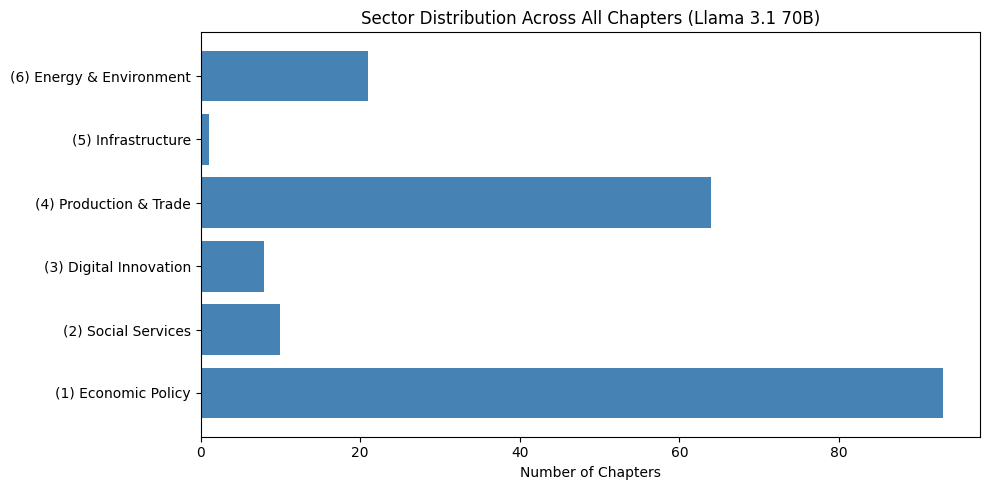

Saved sector_distribution_llama70b.png


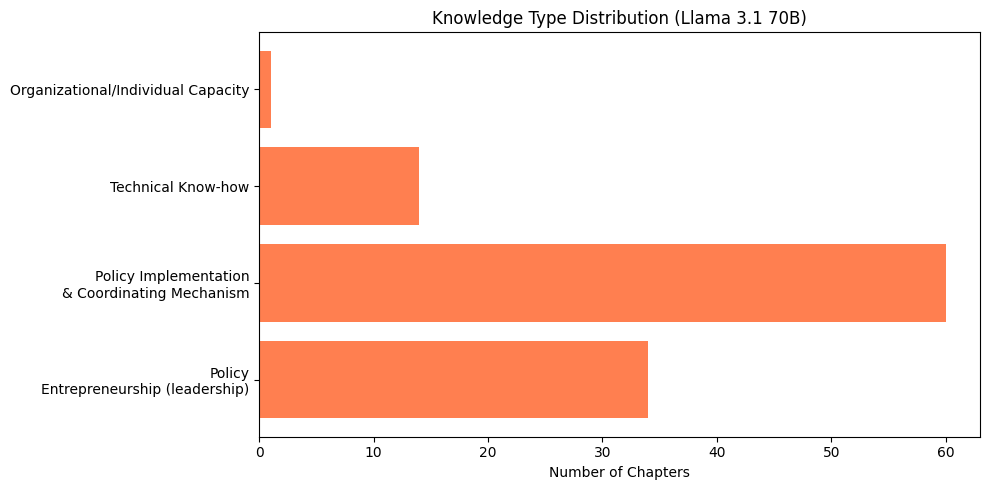

Saved knowledge_type_distribution_llama70b.png


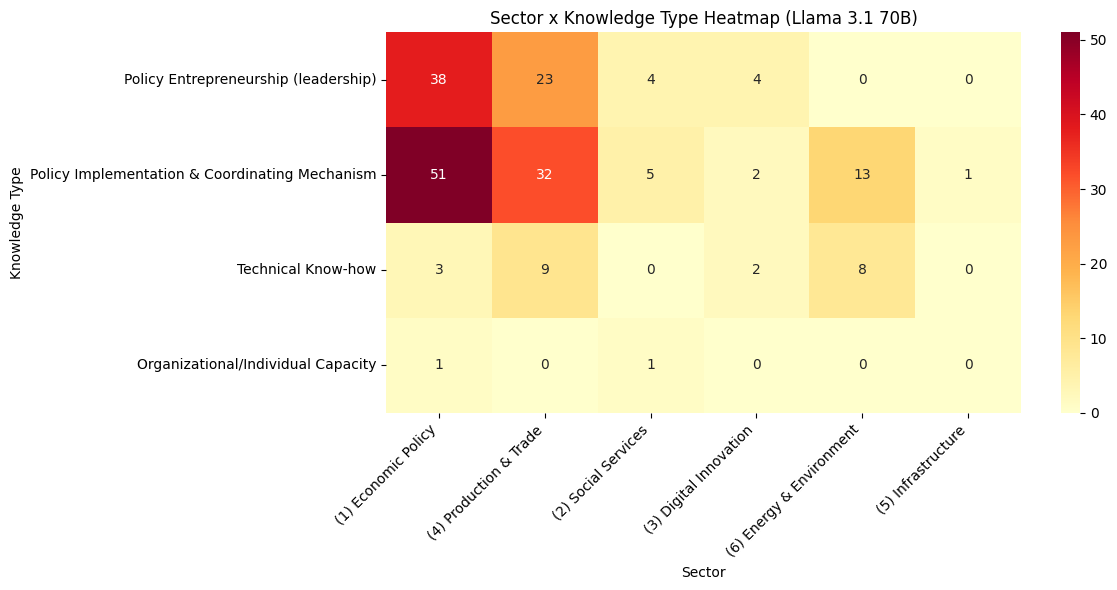

Saved sector_knowledge_heatmap_llama70b.png

PER-REPORT SUMMARY

--- 2009_VNM_Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy_E ---
  Chapters analyzed: 49
  Korean policies extracted: 39
  Top sectors: ['(1) Economic Policy(68), (4) Production & Trade(20), (2) Social Services(3)']
  Knowledge types: {'Policy Entrepreneurship (leadership)': 16, 'Policy Implementation & Coordinating Mechanism': 29, 'Technical Know-how': 3, 'Organizational/Individual Capacity': 1}
  Policies:
    - CAEL Rating System (None)
    - Financial Industry Early Warning System (FIEWS) (2007)
    - Risk Evaluation and Forecasting System (2009)
    - Korean Monetary Policy Framework (None)
    - Korean Financial Crisis Response (1997)
    - Introduction of Credit Unions (1960)
    - Land Reform (1950)
    - Compulsory Education System (1948)
    - Creation of Cooperative Financial Institution (None)
    - Korean R&D Policy (None)
    - Technology Foresight (None)
    - STPEI (

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter


def visualize_results(results: List[Dict]):
    """Generate visualizations from chapter analysis results."""

    # Filter out errors
    valid = [r for r in results if 'taxonomy_classification' in r]
    print(f'Visualizing {len(valid)} successfully analyzed chapters ({len(results) - len(valid)} errors)\n')

    if not valid:
        print('No valid results to visualize')
        return

    suffix = config.output_suffix

    # --- 1. Sector Distribution ---
    sector_counts = Counter()
    for r in valid:
        for s in r['taxonomy_classification'].get('sectors', []):
            sector_counts[s['sector']] += 1

    if sector_counts:
        fig, ax = plt.subplots(figsize=(10, 5))
        sectors = sorted(sector_counts.keys())
        counts = [sector_counts[s] for s in sectors]
        labels = [s.replace('&', '&\n') if len(s) > 25 else s for s in sectors]
        ax.barh(labels, counts, color='steelblue')
        ax.set_xlabel('Number of Chapters')
        ax.set_title('Sector Distribution Across All Chapters (Llama 3.1 70B)')
        plt.tight_layout()
        plt.savefig(f'{config.results_dir}/sector_distribution{suffix}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f'Saved sector_distribution{suffix}.png')

    # --- 2. Knowledge Type Distribution ---
    kt_counts = Counter()
    for r in valid:
        kt = r['taxonomy_classification'].get('knowledge_type', 'Unknown')
        kt_counts[kt] += 1

    if kt_counts:
        fig, ax = plt.subplots(figsize=(10, 5))
        kt_labels = list(kt_counts.keys())
        kt_vals = [kt_counts[k] for k in kt_labels]
        wrapped_labels = []
        for label in kt_labels:
            if len(label) > 35:
                words = label.split()
                mid = len(words) // 2
                wrapped_labels.append(' '.join(words[:mid]) + '\n' + ' '.join(words[mid:]))
            else:
                wrapped_labels.append(label)
        ax.barh(wrapped_labels, kt_vals, color='coral')
        ax.set_xlabel('Number of Chapters')
        ax.set_title('Knowledge Type Distribution (Llama 3.1 70B)')
        plt.tight_layout()
        plt.savefig(f'{config.results_dir}/knowledge_type_distribution{suffix}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f'Saved knowledge_type_distribution{suffix}.png')

    # --- 3. Sector x Knowledge Type Heatmap ---
    if sector_counts and kt_counts:
        cross_data = defaultdict(lambda: defaultdict(int))
        for r in valid:
            kt = r['taxonomy_classification'].get('knowledge_type', 'Unknown')
            for s in r['taxonomy_classification'].get('sectors', []):
                cross_data[s['sector']][kt] += 1

        df_cross = pd.DataFrame(cross_data).fillna(0).astype(int)
        if not df_cross.empty:
            fig, ax = plt.subplots(figsize=(12, 6))
            sns.heatmap(df_cross, annot=True, fmt='d', cmap='YlOrRd', ax=ax)
            ax.set_title('Sector x Knowledge Type Heatmap (Llama 3.1 70B)')
            ax.set_ylabel('Knowledge Type')
            ax.set_xlabel('Sector')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(f'{config.results_dir}/sector_knowledge_heatmap{suffix}.png', dpi=150, bbox_inches='tight')
            plt.show()
            print(f'Saved sector_knowledge_heatmap{suffix}.png')

    # --- 4. Per-Report Summary ---
    print('\n' + '='*60)
    print('PER-REPORT SUMMARY')
    print('='*60)

    report_groups = defaultdict(list)
    for r in valid:
        report_groups[r['report_id']].append(r)

    for report_id, chapters in report_groups.items():
        print(f'\n--- {report_id} ---')
        print(f'  Chapters analyzed: {len(chapters)}')

        # Policies
        total_policies = 0
        for ch in chapters:
            policies = ch.get('korean_policies', 'Not Applicable')
            if isinstance(policies, list):
                total_policies += len(policies)
        print(f'  Korean policies extracted: {total_policies}')

        # Top sectors
        ch_sectors = Counter()
        for ch in chapters:
            for s in ch['taxonomy_classification'].get('sectors', []):
                ch_sectors[s['sector']] += 1
        if ch_sectors:
            top = ch_sectors.most_common(3)
            print(f'  Top sectors: {[", ".join(f"{s}({c})" for s, c in top)]}')

        # Knowledge types
        ch_kt = Counter(ch['taxonomy_classification'].get('knowledge_type', 'Unknown') for ch in chapters)
        print(f'  Knowledge types: {dict(ch_kt)}')

        # Show policies
        if total_policies > 0:
            print(f'  Policies:')
            for ch in chapters:
                policies = ch.get('korean_policies', 'Not Applicable')
                if isinstance(policies, list):
                    for p in policies:
                        yr = p.get('year_initiated', '?')
                        print(f'    - {p["policy_name"]} ({yr})')


# Run visualization
if 'analysis_results' in locals() and analysis_results:
    visualize_results(analysis_results)
else:
    # Try loading from file
    results_path = f'{config.results_dir}/chapter_analysis{config.output_suffix}.json'
    if os.path.exists(results_path):
        with open(results_path) as f:
            analysis_results = json.load(f)
        print(f'Loaded {len(analysis_results)} results from file')
        visualize_results(analysis_results)
    else:
        print('No analysis results found. Run Section 9 first.')


DETAILED VIEW: 2023_KAZ_Project on Extending the Life of Old Power Plants and Improving Energy Efficiency of Aging Power Plants in Kazakhstan

  [L1] A. Background of the Project
    Pages 13-15 | 5856 chars
    Sector: (6) Energy & Environment > Energy > Energy Policy & Access
    Keywords: Energy Efficiency, Renewable Energy Generation, Greenhouse Gas (GHG) Reduction
    Knowledge type: Policy Implementation & Coordinating Mechanism
    Confidence: high
    Korean policies: Not Applicable
    Theory: Technological Progress (Chapter 3 Classic Theories of Economic Growth and Development) - The chapter mentions Kazakhstan's plans to improve energy efficiency and transit

  [L1] B. Project Execution
    Pages 16-22 | 5566 chars
    Sector: (6) Energy & Environment > Energy > Energy Generation & Supply
    Keywords: Energy Efficiency, Renewable Energy Generation
    Knowledge type: Policy Implementation & Coordinating Mechanism
    Confidence: high
    Korean policies: Not Applicable
   

/tmp/ipython-input-445748513.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


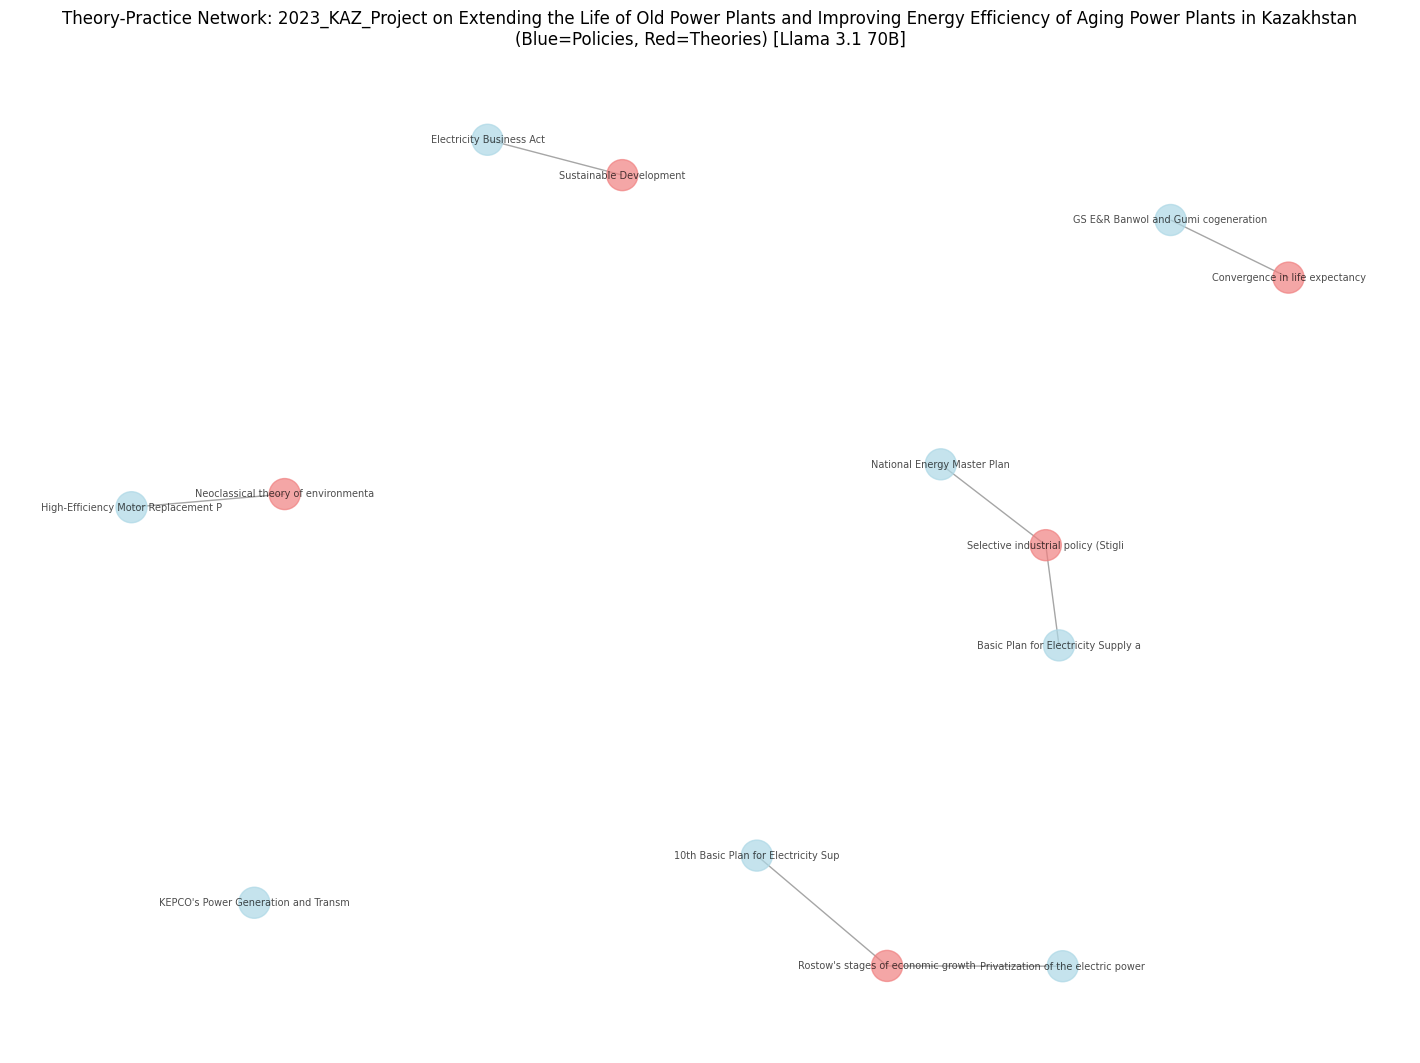


DETAILED VIEW: 2009_VNM_Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy_E

  [L1] 1. Assessment of Vietnam’s Economic Growth Performance
    Pages 31-31 | 1530 chars
    Sector: (1) Economic Policy > Macroeconomic Policy & Stability > Inclusive & Sustainable Growth
    Keywords: Growth Diagnostics & Strategy, Economic Growth Strategy
    Knowledge type: Policy Entrepreneurship (leadership)
    Confidence: high
    Korean policies: Not Applicable
    Theory: Rostow's stages of growth model - The chapter mentions the concept of growth takeoff and sustained growth, which i
    Theory: Solow growth model - The chapter discusses the importance of institutions in sustaining growth, which

  [L1] 2. Projection of GDP Growth
    Pages 32-33 | 4046 chars
    Sector: (1) Economic Policy > Macroeconomic Policy & Stability > Growth Diagnostics & Strategy
    Keywords: Economic Growth Strategy, Structural Reform, Productivity Analysis
    Knowledge type: Polic

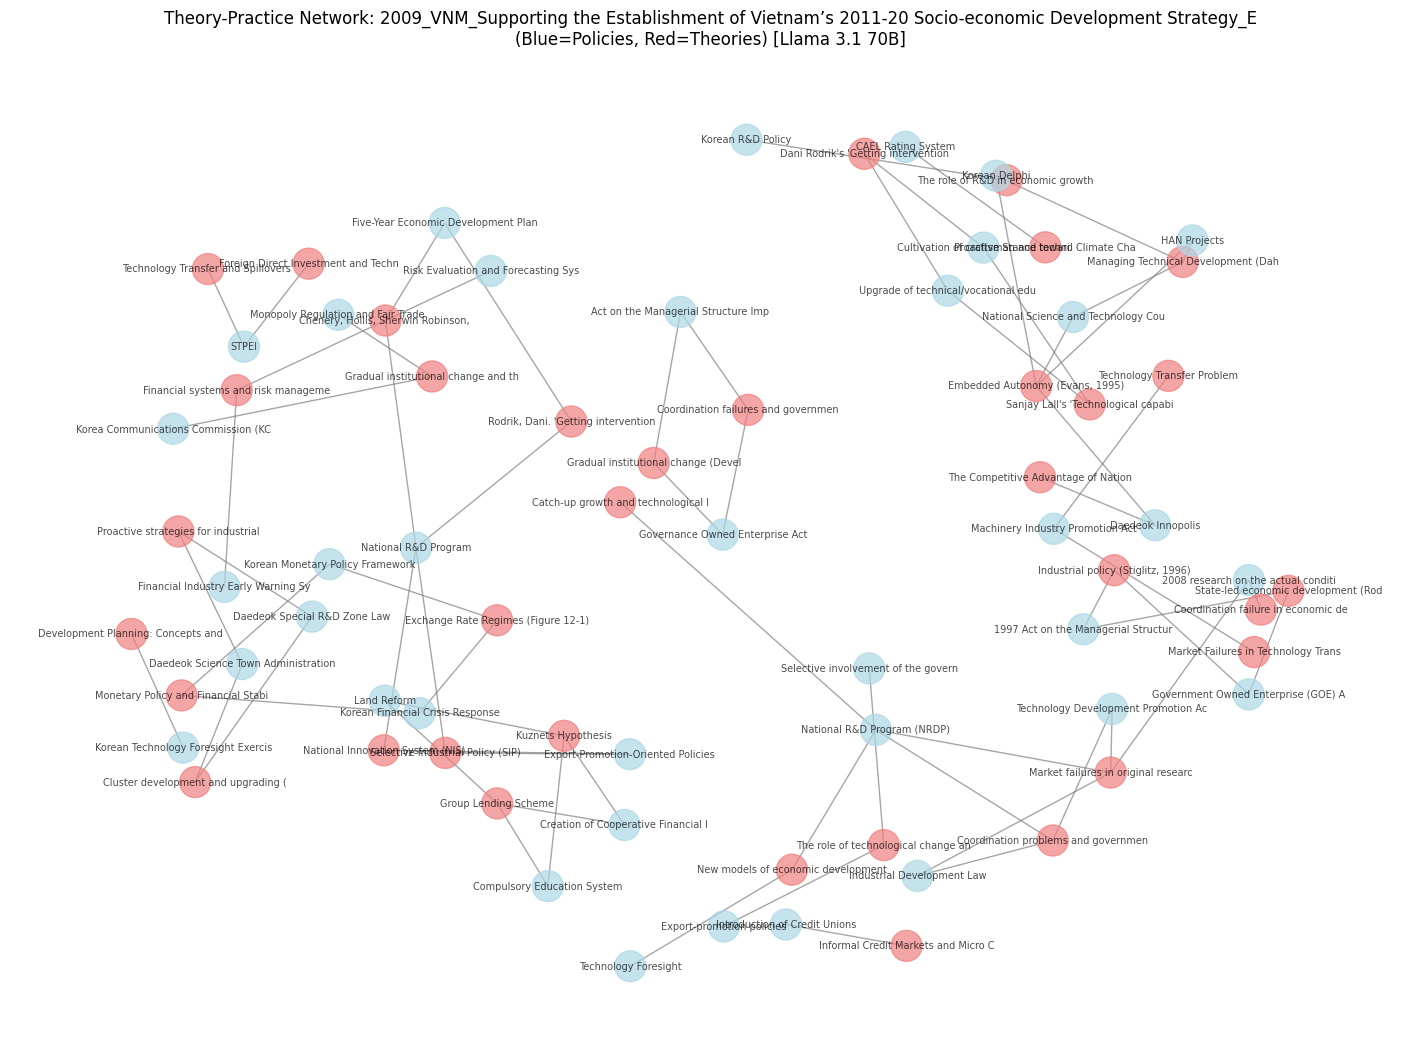


DETAILED VIEW: 2014_SLV_Developing an Innovation Ecosystem... Plastics Pharmaceutical and Cosmetics and Textile Industries

  [L1] 2014/15 KSP with El Salvador
    Pages 15-18 | 8056 chars
    Sector: (1) Economic Policy > Inclusive & Sustainable Growth > Growth Diagnostics & Strategy
    Keywords: Economic Growth Strategy, Structural Reform, Productivity Analysis
    Sector: (4) Production & Trade > Industry & Services > Industrial Development
    Keywords: Industrial Policy, Manufacturing
    Knowledge type: Policy Entrepreneurship (leadership)
    Confidence: high
    Korean policies: Not Applicable
    Related theories: Not Applicable

  [L1] Executive Summary
    Pages 19-24 | 13706 chars
    Sector: (1) Economic Policy > Inclusive & Sustainable Growth > Growth Diagnostics & Strategy
    Keywords: Innovation Ecosystem, Industrial Development, Science, Technology and Innovation (STI)
    Sector: (2) Social Services > Education > Levels of Education
    Keywords: Vocational Trainin

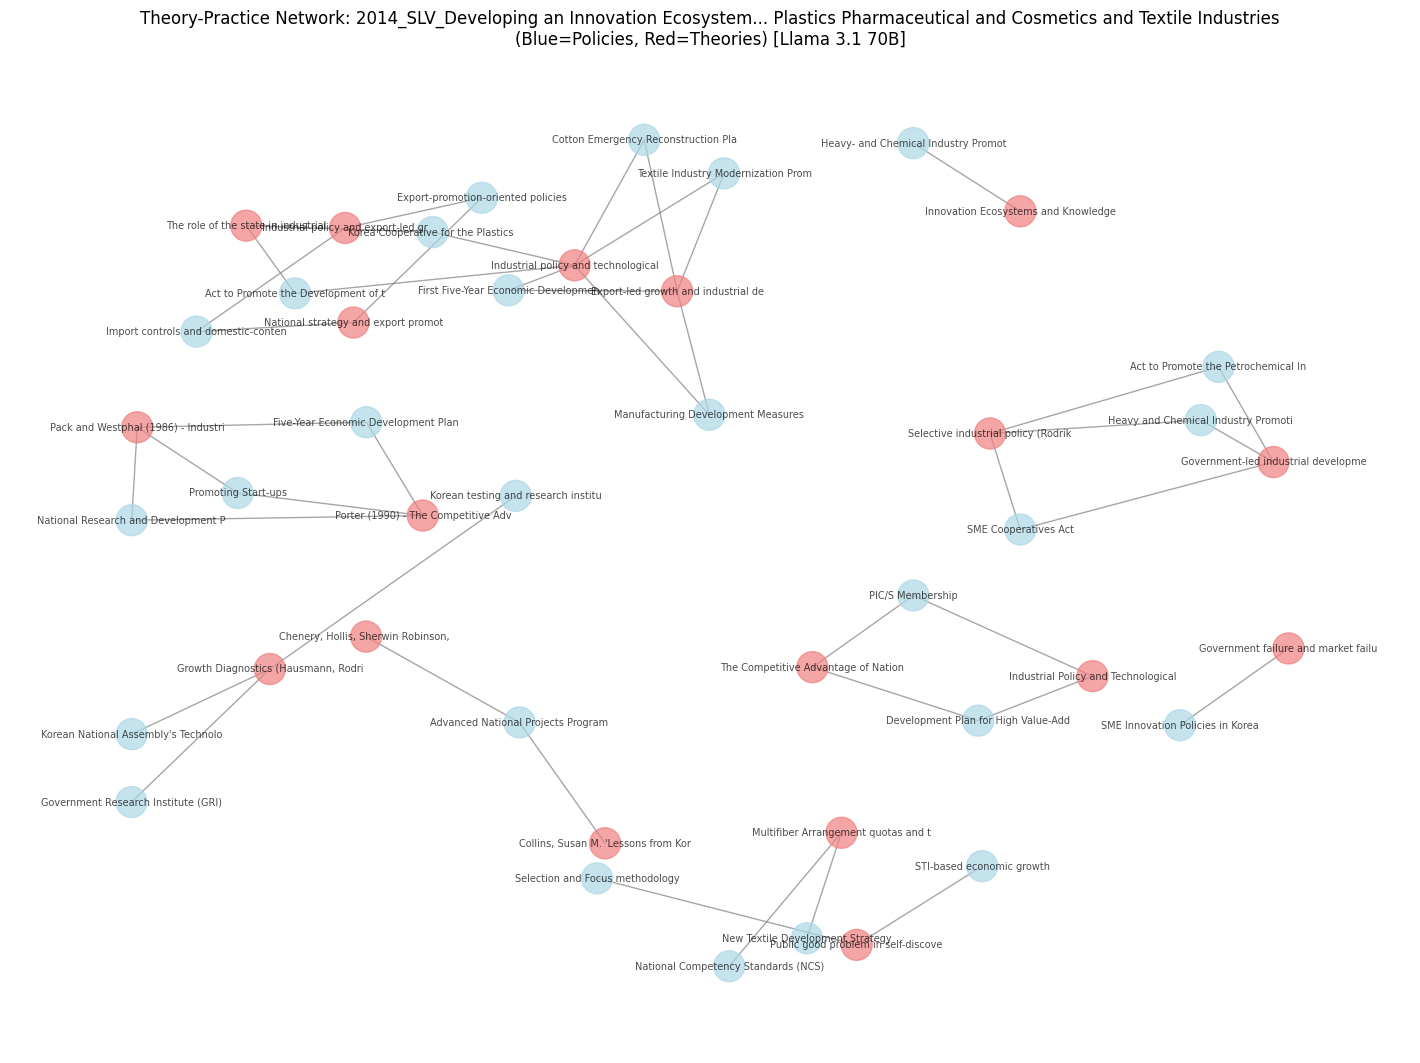


DETAILED VIEW: 2023_QAT_Climate Smart Agriculture and Indoor Farming in Qatar

  [L1] 1. Project Background and Objectives
    Pages 15-18 | 3524 chars
    Sector: (4) Production & Trade > Agriculture, Forestry & Fisheries > Agricultural Development
    Keywords: Agricultural Policy & Administration, Sustainable Agriculture, Agricultural Value Chains
    Sector: (6) Energy & Environment > Climate Change > Climate Change Adaptation
    Keywords: Climate Adaptation Strategies, Climate Resilient Infrastructure
    Knowledge type: Policy Implementation & Coordinating Mechanism
    Confidence: high
    Korean policies: Not Applicable
    Theory: Global Climate Change and Sustainable Development (Development Economics textbook) - The chapter discusses the impact of climate change on Qatar's agricultural devel
    Theory: Asset Poverty and Local Conditioning Variables (Development Economics textbook) - The chapter highlights the challenges faced by Qatar in terms of food security a

  [L1] 1

/tmp/ipython-input-445748513.py:87: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{config.results_dir}/network_{safe_name}{suffix}.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-445748513.py:87: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{config.results_dir}/network_{safe_name}{suffix}.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-445748513.py:87: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{config.results_dir}/network_{safe_name}{suffix}.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-445748513.py:87: UserWarning: Glyph 45453 (\N{HANGUL SYLLABLE NONG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{config.results_dir}/network_{safe_name}{suffix}.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-445748513.py:87: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from font(s) Deja

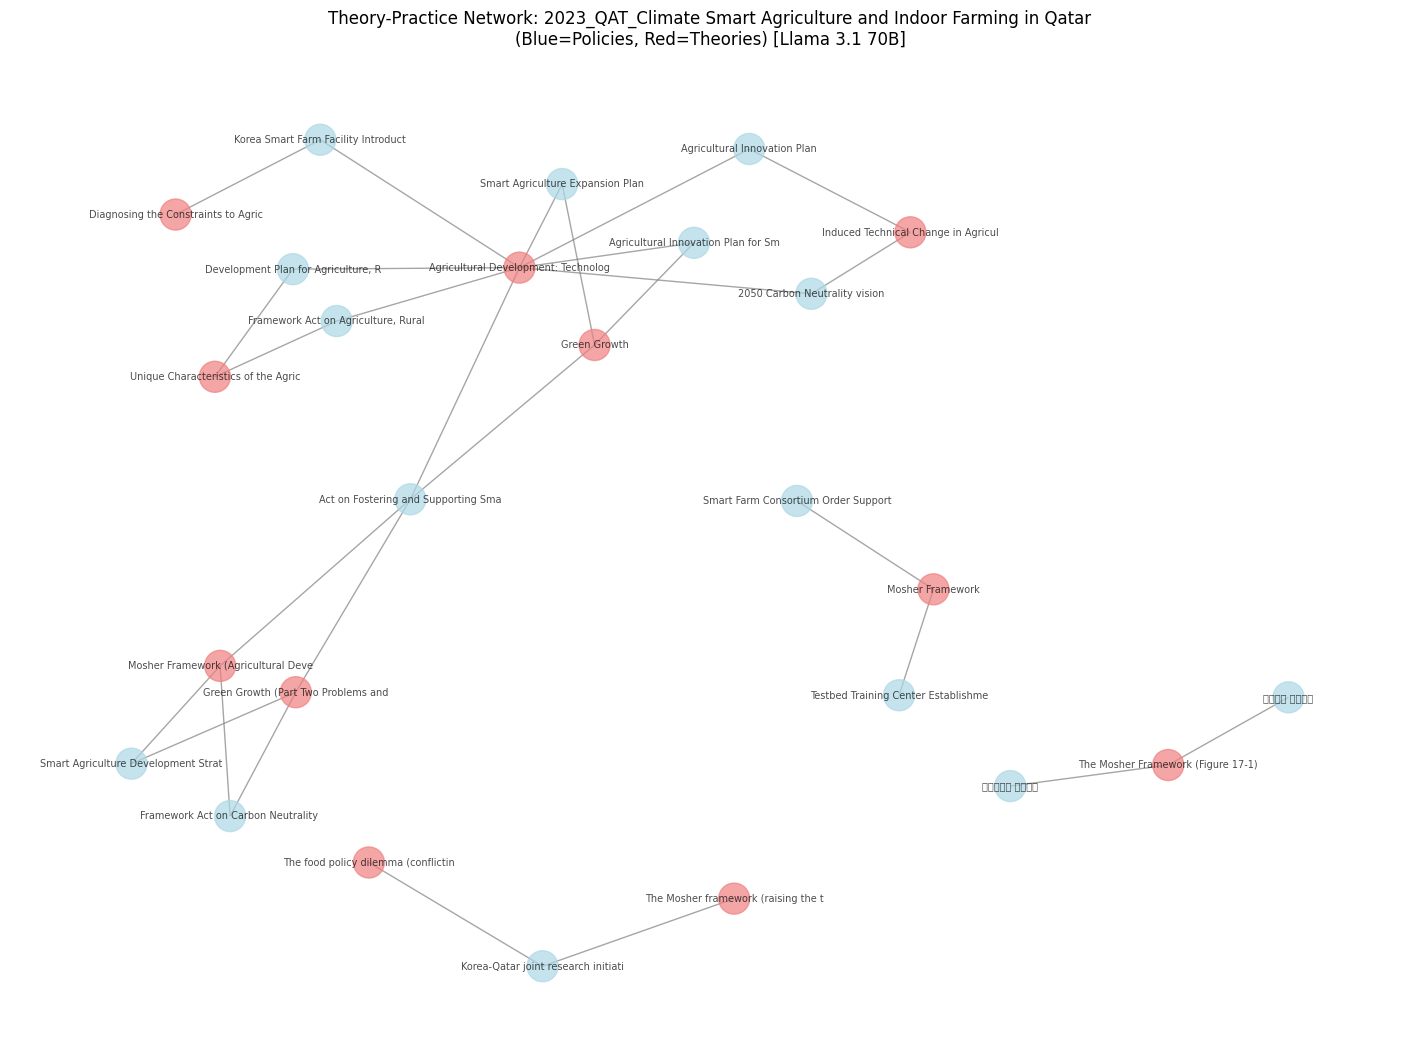

In [18]:
# Detailed chapter-level view for one report
import networkx as nx


def show_detailed_report(results: List[Dict], report_id: str = None):
    """Show detailed chapter-by-chapter view for a specific report."""

    valid = [r for r in results if 'taxonomy_classification' in r]
    if report_id:
        report_chapters = [r for r in valid if r['report_id'] == report_id]
    else:
        if not valid:
            print('No valid results')
            return
        report_id = valid[0]['report_id']
        report_chapters = [r for r in valid if r['report_id'] == report_id]

    print(f'\nDETAILED VIEW: {report_id}')
    print('='*80)

    for ch in report_chapters:
        indent = '  ' * ch.get('chapter_level', 0)
        print(f'\n{indent}[L{ch.get("chapter_level", 0)}] {ch["chapter_title"]}')
        print(f'{indent}  Pages {ch["page_start"]}-{ch["page_end"]} | {ch["content_length"]} chars')

        tc = ch['taxonomy_classification']
        for s in tc.get('sectors', []):
            kws = ', '.join(s.get('keywords', []))
            print(f'{indent}  Sector: {s["sector"]} > {s.get("sub_sector_l1", "")} > {s.get("sub_sector_l2", "")}')
            print(f'{indent}  Keywords: {kws}')
        print(f'{indent}  Knowledge type: {tc.get("knowledge_type", "N/A")}')
        print(f'{indent}  Confidence: {tc.get("confidence", "N/A")}')

        policies = ch.get('korean_policies', 'Not Applicable')
        if isinstance(policies, list) and policies:
            for p in policies:
                print(f'{indent}  Policy: {p["policy_name"]} ({p.get("year_initiated", "?")}) [{p.get("sector", "")}]')
                print(f'{indent}    Org: {p.get("organization", "N/A")}')
                print(f'{indent}    Challenge: {p.get("challenge_addressed", "N/A")}')
                instruments = p.get('policy_instruments', [])
                if instruments:
                    print(f'{indent}    Instruments: {", ".join(instruments)}')
                quote = p.get('evidence_quote', '')
                if quote:
                    print(f'{indent}    Evidence: "{quote[:100]}..."')
        elif policies == 'Not Applicable':
            print(f'{indent}  Korean policies: Not Applicable')

        theories = ch.get('related_theories', 'Not Applicable')
        if isinstance(theories, list) and theories:
            for t in theories:
                print(f'{indent}  Theory: {t.get("theory", "")} - {t.get("relevance", "")[:80]}')
        elif theories == 'Not Applicable':
            print(f'{indent}  Related theories: Not Applicable')

    # Theory-Practice Network for this report
    suffix = config.output_suffix
    policies_for_network = []
    for ch in report_chapters:
        policies = ch.get('korean_policies', 'Not Applicable')
        theories = ch.get('related_theories', 'Not Applicable')
        if isinstance(policies, list):
            for p in policies:
                p_theories = theories if isinstance(theories, list) else []
                policies_for_network.append((p, p_theories))

    if policies_for_network:
        G = nx.Graph()
        for policy, theories in policies_for_network:
            pname = policy['policy_name'][:35]
            G.add_node(pname, node_type='policy')
            for t in theories:
                tname = t.get('theory', '')[:35]
                if tname:
                    G.add_node(tname, node_type='theory')
                    G.add_edge(pname, tname)

        if G.number_of_nodes() > 0:
            plt.figure(figsize=(14, 10))
            pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
            colors = ['lightblue' if G.nodes[n].get('node_type') == 'policy' else 'lightcoral' for n in G.nodes()]
            nx.draw(G, pos, node_color=colors, with_labels=True, font_size=7,
                    node_size=500, alpha=0.7, edge_color='gray')
            plt.title(f'Theory-Practice Network: {report_id}\n(Blue=Policies, Red=Theories) [Llama 3.1 70B]')
            plt.tight_layout()
            safe_name = report_id.replace(' ', '_')[:50]
            plt.savefig(f'{config.results_dir}/network_{safe_name}{suffix}.png', dpi=150, bbox_inches='tight')
            plt.show()


# Show detailed view for each report
if 'analysis_results' in locals() and analysis_results:
    report_ids = list(set(r['report_id'] for r in analysis_results if 'taxonomy_classification' in r))
    for rid in report_ids:
        show_detailed_report(analysis_results, rid)

## Section 11: Summary & Next Steps

In [19]:
print('\n' + '='*60)
print('CHAPTER-LEVEL ANALYSIS COMPLETE (Llama 3.1 70B via Together AI)')
print('='*60)

suffix = config.output_suffix
print(f'\nResults saved in: {config.project_dir}')
print('\nKey outputs:')
print(f'  1. Chapter summaries: {config.processed_dir}/chapter_summaries.json')
print(f'  2. Full analysis: {config.results_dir}/chapter_analysis{suffix}.json')
print(f'  3. Visualizations: {config.results_dir}/*{suffix}.png')
print(f'  4. Textbook vectors: {config.vector_db_dir}/')

# Load and display summary stats
if 'analysis_results' in locals() and analysis_results:
    valid = [r for r in analysis_results if 'taxonomy_classification' in r]
    errors = len(analysis_results) - len(valid)

    total_policies = sum(
        len(r['korean_policies'])
        for r in valid
        if isinstance(r.get('korean_policies'), list)
    )

    chapters_with_policies = sum(
        1 for r in valid
        if isinstance(r.get('korean_policies'), list) and len(r['korean_policies']) > 0
    )

    chapters_with_theories = sum(
        1 for r in valid
        if isinstance(r.get('related_theories'), list) and len(r['related_theories']) > 0
    )

    print(f'\nSummary Statistics:')
    print(f'  Model: {config.llm_model} (Together AI API)')
    print(f'  Reports processed: {len(set(r["report_id"] for r in analysis_results))}')
    print(f'  Chapters analyzed: {len(valid)} ({errors} errors)')
    print(f'  JSON parse success rate: {len(valid)}/{len(analysis_results)} ({len(valid)/len(analysis_results)*100:.0f}%)')
    print(f'  Korean policies extracted: {total_policies} (in {chapters_with_policies} chapters)')
    print(f'  Chapters with theory links: {chapters_with_theories}')

    # Sector coverage
    all_sectors = Counter()
    for r in valid:
        for s in r['taxonomy_classification'].get('sectors', []):
            all_sectors[s['sector']] += 1
    print(f'  Sector coverage: {len(all_sectors)} sectors used')
    for sector, count in all_sectors.most_common():
        print(f'    {sector}: {count} chapters')

print('\nNext steps:')
print('  1. Compare chapter_analysis_llama70b.json with chapter_analysis.json (Claude)')
print('  2. Evaluate taxonomy classification accuracy vs Claude')
print('  3. Assess Korean policy extraction quality')
print('  4. Compare with 8B results to assess quality gain from larger model')

print('\n' + '='*60)


CHAPTER-LEVEL ANALYSIS COMPLETE (Llama 3.1 70B via Together AI)

Results saved in: /content/drive/MyDrive/KM4D_v0

Key outputs:
  1. Chapter summaries: /content/drive/MyDrive/KM4D_v0/data/processed/chapter_summaries.json
  2. Full analysis: /content/drive/MyDrive/KM4D_v0/data/results/chapter_analysis_llama70b.json
  3. Visualizations: /content/drive/MyDrive/KM4D_v0/data/results/*_llama70b.png
  4. Textbook vectors: /content/drive/MyDrive/KM4D_v0/vector_db/

Summary Statistics:
  Model: meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo (Together AI API)
  Reports processed: 4
  Chapters analyzed: 109 (3 errors)
  JSON parse success rate: 109/112 (97%)
  Korean policies extracted: 89 (in 50 chapters)
  Chapters with theory links: 105
  Sector coverage: 6 sectors used
    (1) Economic Policy: 93 chapters
    (4) Production & Trade: 64 chapters
    (6) Energy & Environment: 21 chapters
    (2) Social Services: 10 chapters
    (3) Digital Innovation: 8 chapters
    (5) Infrastructure: 1 chapter